In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from synthpop.models.ultravox_populi import UltravoxPopuli
from synthpop.infer import Infer, VI, SMCABC
from synthpop.generative import MaskedAutoRegressiveFlow, SampleGenerator
import pygtc

/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
n_agents = 500
n_timesteps = 500
model = UltravoxPopuli(n_timesteps=n_timesteps, n_agents=n_agents)
#prior_pars = [0.6, 4, 0.1, 5, 0.1] + [1]
#generator = UltravoxPopuli.make_default_generator((prior_pars))
#x=model(generator)

# Define "complexity" of the signal as total variation (i.e. one-variation) of series
# Maximum value of one-variation of piecewise linear path in [0,1] over N unit increments is N - 1,
# so consider distance below this maximum value
# Regularise by penalising time spent in absorbing states at (mean_opinion = 1) and (mean_opinion = 0)
def sbi_one_variation(x):
    x = x[0]
    return x.shape[0] - np.abs(x[1:] - x[:-1]).sum() + (x < 1./n_agents).sum() + (x > 1 - 1./n_agents).sum()

### SMC ABC

In [25]:
# sample meta generator
class SampleMetaGenerator(SampleGenerator):
    def forward(self, generator_params):
        # append m to 2
        generator_params = np.append(generator_params, 2)
        return UltravoxPopuli.make_default_generator(generator_params)

In [26]:
# Parameters: 
# Probability for Bernoulli random variable that assigns initial opinions to each agent; 
# Two parameters for Beta distribution over stubbornness parameter 1
# Same again for second stubbornness parameter
prior_min = [0.,0.,0.,0.,0.]
prior_max = [1.,5.,5.,5.,5.]
prior = torch.distributions.Independent(torch.distributions.Uniform(torch.tensor(prior_min), torch.tensor(prior_max)), 1)

In [27]:
sample_meta_generator = SampleMetaGenerator()
infer = Infer(model=model, meta_generator=sample_meta_generator, prior=prior, loss=sbi_one_variation)
infer_method = SMCABC(num_particles = 100, num_initial_pop=1_000, num_simulations=2_000, epsilon_decay=0.8)
trained_meta_generator = infer.fit(infer_method, num_workers=-1)

Running 1000 simulations in 1000 batches.:   0%|          | 0/1000 [00:00<?, ?it/s]/Users/arnull/code/synthpop/synthpop/models/ultravox_populi.py:49: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'neighbours' of function '_step'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../synthpop/models/ultravox_populi.py", line 16:
@njit
def _step(os, mus, gammas, N, neighbours):
^

  os = _step(os, mus, gammas, N, each_agents_neighbours)
/Users/arnull/miniconda3/envs/torch2/lib/python3.10/site-packages/numba/core/ir_utils.py:2147: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'each_agents_neighbours' of function '_simulate'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecat

In [28]:
untrained_sample_meta_generator = SampleMetaGenerator()
prior_runs = [model.run(untrained_sample_meta_generator(prior.sample())) for _ in range(25)]
trained_runs = [model.run(trained_meta_generator()) for _ in range(25)]
avg_loss = np.mean([sbi_one_variation(xx) for xx in trained_runs])
print(f"Average loss is {avg_loss}")

Average loss is 589.6276


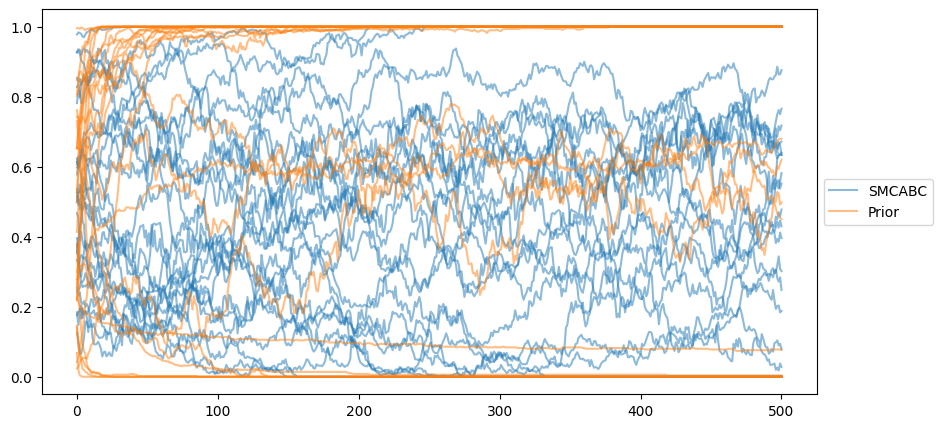

In [29]:
f, ax = plt.subplots(figsize=(10,5))
alpha = 0.5
for run in trained_runs:
    ax.plot(run[0], alpha = 0.5, color = "C0")

for run in prior_runs:
    ax.plot(run[0], alpha = 0.5, color = "C1")

ax.plot([], [], alpha=alpha, color="C0", label = "SMCABC")
ax.plot([], [], alpha=alpha, color="C1", label = "Prior")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# VI

In [30]:

class FlowMetaGenerator(MaskedAutoRegressiveFlow):
    prior_min = 1e-4 * torch.ones(5)
    prior_max = torch.tensor([1.,5.,5.,5.,5.])
    def forward(self, generator_params=None):
        with torch.no_grad():
            if generator_params is None:
                generator_params = self.sample(1)[0][0]
            generator_params = torch.exp(generator_params)
            # clamp params to prior lims
            generator_params = torch.max(generator_params, self.prior_min)
            generator_params = torch.min(generator_params, self.prior_max)
            generator_params = torch.hstack((generator_params, torch.tensor([2])))
        return UltravoxPopuli.make_default_generator(generator_params.numpy())


In [34]:
flow_meta_generator = FlowMetaGenerator(n_parameters = 5, n_hidden_units = 64, n_transforms = 8)
# make aux prior so that regularisation loss is the entropy.
inff = 1000
prior_vi = torch.distributions.Independent(torch.distributions.Uniform(-inff * torch.ones(5), inff * torch.ones(5)), 1)
infer = Infer(model=model, meta_generator=flow_meta_generator, prior=prior_vi, loss=sbi_one_variation)
optimizer = torch.optim.AdamW(flow_meta_generator.parameters(), lr=1e-3)
infer_method = VI(w=1e-2, n_samples_per_epoch=25, optimizer=optimizer, 
                    progress_bar=True, progress_info=True, gradient_estimation_method="score", log_tensorboard=True, n_samples_regularisation=10000)
infer.fit(infer_method, n_epochs=1000, max_epochs_without_improvement=50);

 11%|█         | 109/1000 [02:04<16:55,  1.14s/it, loss=504.60, reg=0.36, total=504.96, best loss=495.58, epochs since improv.=50]


In [35]:
flow_meta_generator.load_state_dict(torch.load("./best_estimator.pt"))
flow_trained_runs = [model.run(flow_meta_generator()) for _ in range(25)]
avg_loss = np.mean([sbi_one_variation(xx) for xx in flow_trained_runs])
print(f"Averaged loss: {avg_loss}")

Averaged loss: 534.9464800000001


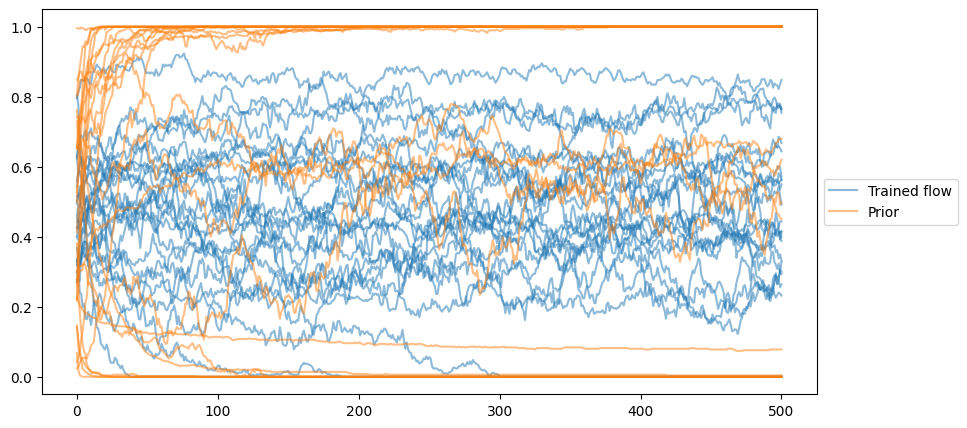

In [36]:
f, ax = plt.subplots(figsize=(10,5))
alpha = 0.5
for run in flow_trained_runs:
    ax.plot(run[0], alpha = alpha, color = "C0")

for run in prior_runs:
    ax.plot(run[0], alpha = alpha, color = "C1")

ax.plot([], [], alpha=alpha, color="C0", label = "Trained flow")
ax.plot([], [], alpha=alpha, color="C1", label = "Prior")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))